In [3]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

C:\Users\Chainsword\AppData\Local\Temp\ipykernel_32788\2671113500.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [4]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [5]:
df = process_experiment(
    r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025Mar10-213212_configs"
)
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'estimator.args_.lin_hidden_out_size', 'seed', 'experiment_name'],
      dtype='object')

In [6]:
df

,epoch_type,frame_stamp,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,episode_discounted_rewards_mean,...,episode_max_qs_max,episode_max_qs_mean,episode_max_qs_median,episode_max_qs_std,policy_trained_times,target_trained_times,epoch_time,estimator.args_.lin_hidden_out_size,seed,experiment_name
0,training,200000,-1154.677981,-42.548975,-51.730521,-45.325443,80.707921,-22.378407,-18.833048,-19.347983,...,-0.330927,-0.528146,-0.525559,0.196587,48749.0,48.0,0 days 00:02:26.374540,32,0,0000_estimator.args_.lin_hidden_out_size_32
1,training,400000,-27276.989430,-1466.758209,-2823.480564,-2184.685628,3798.510134,-24.421731,-18.922179,-24.145909,...,0.276655,-1.150688,-1.035955,0.727276,50000.0,48.0,0 days 00:02:28.304919,32,0,0000_estimator.args_.lin_hidden_out_size_32
2,training,600000,-4211.894696,-1235.715777,-2374.446992,-2250.711143,649.022181,-24.421731,-22.590197,-24.204916,...,-0.490279,-1.370039,-1.004162,0.858911,50000.0,52.0,0 days 00:02:59.967445,32,0,0000_estimator.args_.lin_hidden_out_size_32
3,training,800000,-3627.908929,-69.366573,-103.779732,-72.035637,271.119485,-24.421731,-21.488960,-22.281714,...,-0.431494,-1.678829,-1.405740,1.058466,50000.0,48.0,0 days 00:03:29.486197,32,0,0000_estimator.args_.lin_hidden_out_size_32
4,training,1000000,-72.035637,-70.985873,-71.940972,-72.035637,0.273066,-22.261641,-22.203669,-22.259935,...,-0.840694,-2.262122,-1.873263,1.011667,50000.0,52.0,0 days 00:02:54.647042,32,0,0000_estimator.args_.lin_hidden_out_size_32
5,training,1200000,-72.035637,-71.000411,-71.949516,-72.035637,0.260737,-22.261641,-22.215756,-22.260089,...,-0.818028,-2.189952,-1.809928,0.977820,50000.0,48.0,0 days 00:02:34.796184,32,0,0000_estimator.args_.lin_hidden_out_size_32
6,training,1400000,-107.330270,-66.399206,-71.948493,-72.035637,0.622841,-23.910241,-21.818480,-22.260254,...,-0.823824,-2.280093,-1.904296,1.005924,50000.0,52.0,0 days 00:02:34.850317,32,0,0000_estimator.args_.lin_hidden_out_size_32
7,training,1600000,-72.035637,-71.013133,-71.941915,-72.035637,0.271853,-22.261641,-22.205584,-22.259903,...,-0.634015,-2.419774,-2.071966,1.027177,50000.0,48.0,0 days 00:02:29.342565,32,0,0000_estimator.args_.lin_hidden_out_size_32
8,training,1800000,-72.035637,-70.980347,-71.943466,-72.035637,0.269119,-22.261641,-22.195989,-22.260016,...,-0.695009,-2.496989,-2.216808,1.096186,50000.0,52.0,0 days 00:02:38.321094,32,0,0000_estimator.args_.lin_hidden_out_size_32
9,training,2000000,-72.035637,-70.980147,-71.936862,-72.035637,0.278106,-22.261641,-22.209672,-22.259917,...,-0.614159,-2.515605,-2.223511,1.123831,50000.0,48.0,0 days 00:02:25.372647,32,0,0000_estimator.args_.lin_hidden_out_size_32


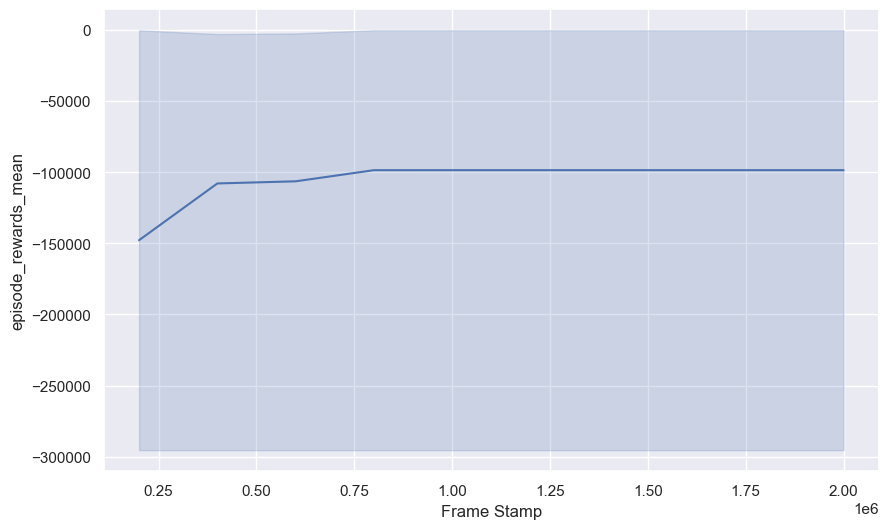

In [7]:

selected_metric = 'episode_rewards_mean'

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=df, x='frame_stamp', y=selected_metric)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
# plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()